# Generating spike trains from a synthetic connectome

In this notebook, we generate spiketrains from a recurrent E-I network with current-based LIF neurons, and assembly connectivity inspired by zebrafish Dp.

### Overview
1. First we generate a biologically plausible recurrent weight matrix with a Dp-inspired assembly structure.
2. Next we generate excitatory mitral cell inputs from the OB with Poisson stastics and sparse projections.
3. Then we initialise our network with parameters adapted from [Meissner-Bernard et al. (2025)](https://doi.org/10.1016/j.celrep.2025.115330).
4. Finally we run our network and examine the output dynamics.

In [1]:
#| code-fold: true
#| code-summary: "Setup autoreload"
#| output: false
%load_ext autoreload
%autoreload 2
%xmode Verbose

Exception reporting mode: Verbose


In [2]:
#| code-fold: true
#| code-summary: "Import libraries"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from synthetic_connectome import topology_generators, weight_assigners
from network_simulators.current_lif_network import CurrentLIFNetwork
import torch

repo_root = Path().resolve().parent

In [3]:
#| code-fold: true
#| code-summary: "Select device (CPU/GPU)"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### Load all network parameters

We first load all parameters from a single CSV file that specifies network topology, synaptic weight distributions, feedforward input configuration, and neuron physiology parameters.

In [4]:
# Load network parameters from CSV
params_df = pd.read_csv(repo_root / "parameters" / "Dp-default.csv", comment="#")

In [5]:
#| code-fold: true
#| code-summary: "Extract parameters from dataframe"
# Load parameters into python variables
params = params_df.set_index('symbol')

delta_t = params.loc['delta_t', 'value']
duration = params.loc['duration', 'value']
num_neurons = int(params.loc['num_neurons', 'value'])
num_assemblies = int(params.loc['num_assemblies', 'value'])
p_within = params.loc['p_within', 'value']
p_between = params.loc['p_between', 'value']
p_E = params.loc['p_E', 'value']
w_mu_E = params.loc['w_mu_E', 'value']
w_sigma_E = params.loc['w_sigma_E', 'value']
w_mu_I = params.loc['w_mu_I', 'value']
w_sigma_I = params.loc['w_sigma_I', 'value']
num_mitral = int(params.loc['num_mitral', 'value'])
r_mitral = params.loc['r_mitral', 'value']
p_feedforward = params.loc['p_feedforward', 'value']
w_mu_FF = params.loc['w_mu_FF', 'value']
w_sigma_FF = params.loc['w_sigma_FF', 'value']
scaling_factor_E = params.loc['scaling_factor_E', 'value']
scaling_factor_I = params.loc['scaling_factor_I', 'value']
scaling_factor_FF = params.loc['scaling_factor_FF', 'value']
tau_mem_E = params.loc['tau_mem_E', 'value']
tau_syn_E = params.loc['tau_syn_E', 'value']
R_E = params.loc['R_E', 'value']
U_rest_E = params.loc['U_rest_E', 'value']
theta_E = params.loc['theta_E', 'value']
U_reset_E = params.loc['U_reset_E', 'value']
tau_mem_I = params.loc['tau_mem_I', 'value']
tau_syn_I = params.loc['tau_syn_I', 'value']
R_I = params.loc['R_I', 'value']
U_rest_I = params.loc['U_rest_I', 'value']
theta_I = params.loc['theta_I', 'value']
U_reset_I = params.loc['U_reset_I', 'value']


In [6]:
#| code-fold: true
#| code-summary: "Display parameter table"
# Display all network parameters
print("All Network Parameters")
print("=" * 22)
display(params_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.1f}'}))

All Network Parameters


symbol,unit,description,value
delta_t,ms,Time resolution of the simulation,1.0
duration,ms,Total simulation duration,1000.0
num_neurons,nan,Total number of neurons in the network,5000.0
num_assemblies,nan,Number of assemblies in the network,20.0
p_within,nan,Connection probability within assemblies,0.1
p_between,nan,Connection probability between assemblies,0.0
p_E,nan,Proportion of excitatory neurons,0.8
w_mu_E,voxel,Mean (log-space) for excitatory synaptic weights,1.0
w_sigma_E,voxel,Standard deviation (log-space) for excitatory weights,0.2
w_mu_I,voxel,Mean (log-space) for inhibitory synaptic weights,2.4


### Generate Assembly-Based Topology

We now create an unweighted network with assembly-based connectivity structure. This is a matrix indicating inhibitory/excitatory connections.

We then visualise this graph. Note that the assembly structure is not obvious because by design our matrix is shuffled.

In [7]:
#| code-fold: true
#| code-summary: "Display topology parameters"
# Display network topology parameters
topology_params = params_df[params_df['symbol'].isin(['num_neurons', 'num_assemblies', 'p_within', 'p_between', 'p_E'])]

print("Network Topology Parameters")
print("=" * 62)
display(topology_params.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.1f}'}))

Network Topology Parameters


symbol,unit,description,value
num_neurons,nan,Total number of neurons in the network,5000.0
num_assemblies,nan,Number of assemblies in the network,20.0
p_within,nan,Connection probability within assemblies,0.1
p_between,nan,Connection probability between assemblies,0.0
p_E,nan,Proportion of excitatory neurons,0.8


In [8]:
# Generate assembly-based connectivity graph and neuron types
connectivity_graph, neuron_types = topology_generators.assembly_generator(
    num_neurons=num_neurons,
    num_assemblies=num_assemblies,
    p_within=p_within,
    p_between=p_between,
    p_E=p_E,
)

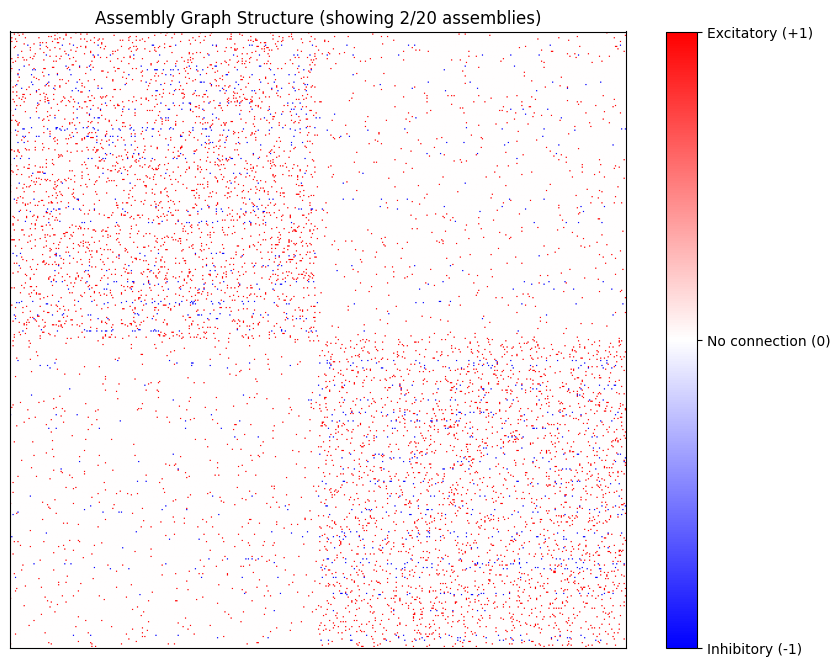

In [9]:
#| code-fold: true
#| code-summary: "Plot connectivity graph"
# Visualize assembly graph structure
plot_num_assemblies = 2  # Number of assemblies to display
neurons_per_assembly = num_neurons // num_assemblies
plot_size_neurons = neurons_per_assembly * plot_num_assemblies

# Fixed size in inches for the heatmap
heatmap_inches = 8  # Bigger fixed size
fig, ax = plt.subplots(figsize=(heatmap_inches * 1.3, heatmap_inches))  # Extra width for colorbar

im = ax.imshow(connectivity_graph[:plot_size_neurons, :plot_size_neurons], cmap="bwr", vmin=-1, vmax=1, aspect='equal')

# Force the axes to be square first
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.height, pos.height])

# Add colorbar after positioning
cbar = plt.colorbar(im, ax=ax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(["Inhibitory (-1)", "No connection (0)", "Excitatory (+1)"])

ax.set_title(f"Assembly Graph Structure (showing {plot_num_assemblies}/{num_assemblies} assemblies)")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

### Assign Synaptic Weights

We now convert the unweighted connectivity graph into a weighted graph, with inhibitory and excitatory synaptic strengths drawn from biologically realistic log-normal distributions.

We want to balance the total synaptic input to each neuron on average. Given that the log-normal distribution has expectation:

$$\mathbb{E}[X] = \exp\left(\mu + \frac{\sigma^2}{2}\right)$$

And we have roughly four times as many excitatory neurons as inhibitory neurons, we can approximately acheive balance by setting:

$$\mu_I = \mu_E + \log{4}$$

We then visualise this graph and check the distribution of input weights to all neurons is roughly balanced.

In [10]:
#| code-fold: true
#| code-summary: "Display weight parameters"
# Display recurrent synaptic weight parameters
weight_params = params_df[params_df['symbol'].isin(['w_mu_E', 'w_sigma_E', 'w_mu_I', 'w_sigma_I'])]

print("Recurrent Synaptic Weight Parameters")
print("=" * 62)
display(weight_params.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.1f}'}))

Recurrent Synaptic Weight Parameters


symbol,unit,description,value
w_mu_E,voxel,Mean (log-space) for excitatory synaptic weights,1.0
w_sigma_E,voxel,Standard deviation (log-space) for excitatory weights,0.2
w_mu_I,voxel,Mean (log-space) for inhibitory synaptic weights,2.4
w_sigma_I,voxel,Standard deviation (log-space) for inhibitory weights,0.2


In [11]:
# Assign log-normal weights to connectivity graph
weights = weight_assigners.assign_weights_lognormal(
    connectivity_graph=connectivity_graph,
    neuron_types=neuron_types,
    w_mu_E=w_mu_E,
    w_sigma_E=w_sigma_E,
    w_mu_I=w_mu_I,
    w_sigma_I=w_sigma_I,
)

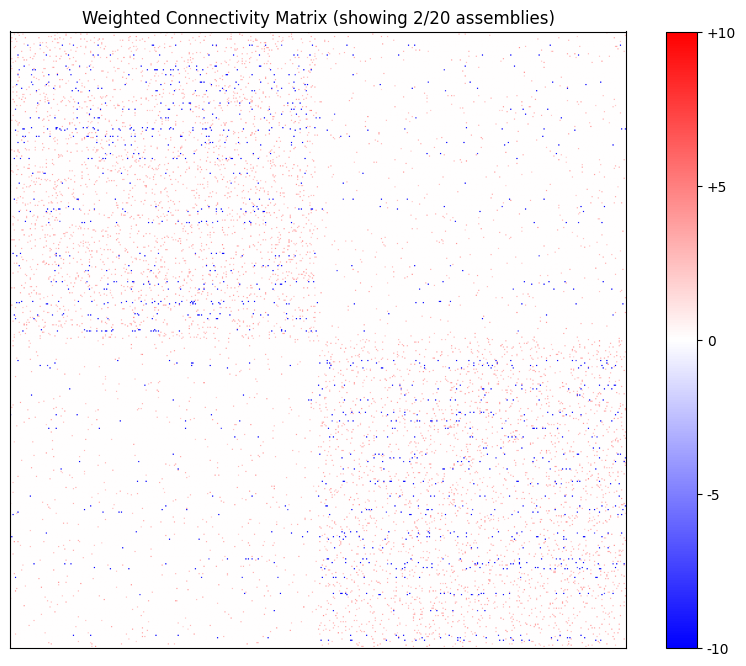

In [12]:
#| code-fold: true
#| code-summary: "Plot weighted connectivity matrix"
# Visualize weighted connectivity matrix
plot_num_assemblies = 2  # Number of assemblies to display
neurons_per_assembly = num_neurons // num_assemblies
plot_size_neurons = neurons_per_assembly * plot_num_assemblies

# Fixed size in inches for the heatmap (same as unweighted)
heatmap_inches = 8  # Bigger fixed size
fig, ax = plt.subplots(figsize=(heatmap_inches * 1.3, heatmap_inches))  # Extra width for colorbar

im = ax.imshow(weights[:plot_size_neurons, :plot_size_neurons], cmap="bwr", vmin=-10, vmax=10, aspect='equal')

# Force the axes to be square first
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.height, pos.height])

# Add colorbar after positioning
cbar = plt.colorbar(im, ax=ax, ticks=[-10, -5, 0, 5, 10])
cbar.ax.set_yticklabels(["-10", "-5", "0", "+5", "+10"])

ax.set_title(f"Weighted Connectivity Matrix (showing {plot_num_assemblies}/{num_assemblies} assemblies)")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

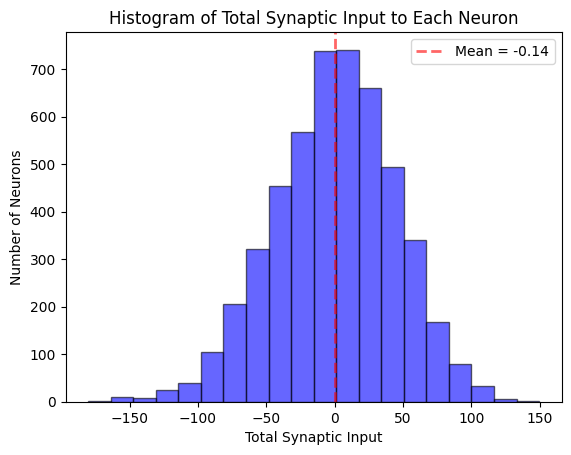

In [13]:
#| code-fold: true
#| code-summary: "Plot synaptic input distribution"
# Plot histogram of total synaptic input to each neuron
synaptic_inputs = weights.sum(axis=0)
mean_input = synaptic_inputs.mean()

fig, ax = plt.subplots()
ax.hist(synaptic_inputs, bins=20, color="#0000FF", edgecolor="black", alpha=0.6)  # Blue from bwr colormap
ax.axvline(mean_input, color="#FF0000", linestyle="--", linewidth=2, alpha=0.6, label=f"Mean = {mean_input:.2f}")  # Red from bwr
ax.set_title("Histogram of Total Synaptic Input to Each Neuron")
ax.set_xlabel("Total Synaptic Input")
ax.set_ylabel("Number of Neurons")
ax.legend()
plt.show()

### Create network inputs

To run our network simulation, we additionally need to define feedforward inputs into the network.

To simulate baseline activity in the zebrafish olfactory bulb (OB), we simulate a population of mitral cells firing with Poisson statistics. These cells then project randomly with sparse connectivity to excitatory cells in our Dp network, with weights generated from a log-normal distribution.

In [14]:
#| code-fold: true
#| code-summary: "Display feedforward parameters"
# Display feedforward input parameters
feedforward_symbols = ['num_mitral', 'r_mitral', 'p_feedforward', 'w_mu_FF', 'w_sigma_FF']
feedforward_params = params_df[params_df['symbol'].isin(feedforward_symbols)]

print("Feedforward Input Parameters")
print("=" * 62)
display(feedforward_params.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.2f}'}))

Feedforward Input Parameters


symbol,unit,description,value
num_mitral,nan,Number of mitral cells (feedforward inputs),1500.00
r_mitral,Hz,Firing rate of mitral cells (Poisson),6.00
p_feedforward,nan,Connection probability from mitral cells to Dp,0.02
w_mu_FF,voxel,Mean (log-space) for feedforward synaptic weights,0.00
w_sigma_FF,voxel,Standard deviation (log-space) for feedforward weights,0.20


In [15]:
# Generate Poisson spike trains for mitral cells
n_steps = int(duration / delta_t)
shape = (1, n_steps, num_mitral)
p_spike = r_mitral * delta_t * 1e-3 # rate in Hz, delta_t in ms
input_spikes = np.random.rand(*shape) < p_spike

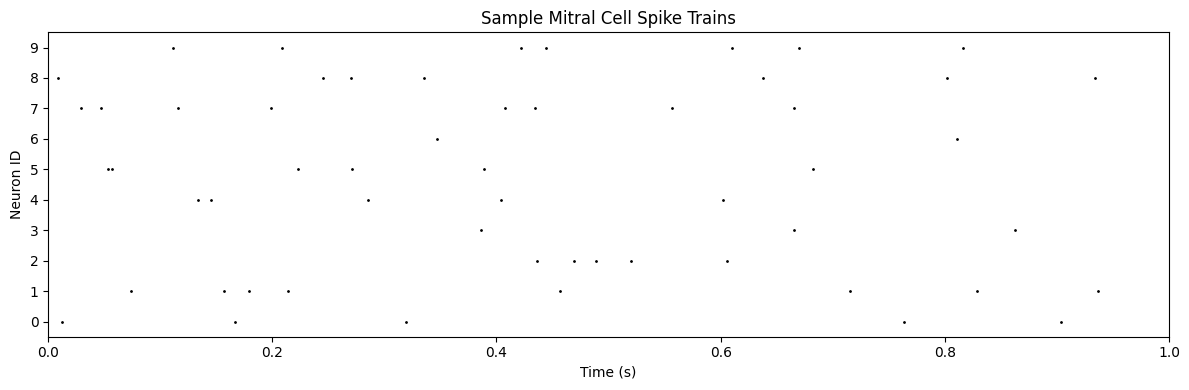

In [16]:
#| code-fold: true
#| code-summary: "Plot mitral cell spike trains"
# Visualize sample mitral cell spike trains
n_neurons_plot = 10
fraction = 1.0 # fraction of duration to plot
fig, ax = plt.subplots(figsize=(12, 4))
spike_times, neuron_ids = np.where(input_spikes[0, :, :n_neurons_plot])
ax.scatter(spike_times * delta_t * 1e-3, neuron_ids, s=1, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neuron ID')
ax.set_title('Sample Mitral Cell Spike Trains')
ax.set_ylim(-0.5, n_neurons_plot - 0.5)
ax.set_yticks(range(n_neurons_plot))
ax.set_xlim(0, duration * 1e-3 * fraction)
plt.tight_layout()
plt.show()

In [17]:
# Generate feedforward connectivity graph and mask inhibitory targets
feedforward_connectivity_graph, _ = topology_generators.sparse_graph_generator(
    num_neurons=(num_mitral, num_neurons),
    p=p_feedforward,
    p_E=1.0,
)
# Set connections to inhibitory cells to zero (only connect to excitatory cells)
inhibitory_cells = np.where(neuron_types == -1)[0]
feedforward_connectivity_graph[:, inhibitory_cells] = 0

In [18]:
# Assign log-normal weights to feedforward connectivity and scale
feedforward_weights = weight_assigners.assign_weights_lognormal(
    connectivity_graph=feedforward_connectivity_graph,
    neuron_types=np.ones(num_mitral),
    w_mu_E=w_mu_FF,
    w_sigma_E=w_sigma_FF,
    w_mu_I=w_mu_I,
    w_sigma_I=w_sigma_I,
)

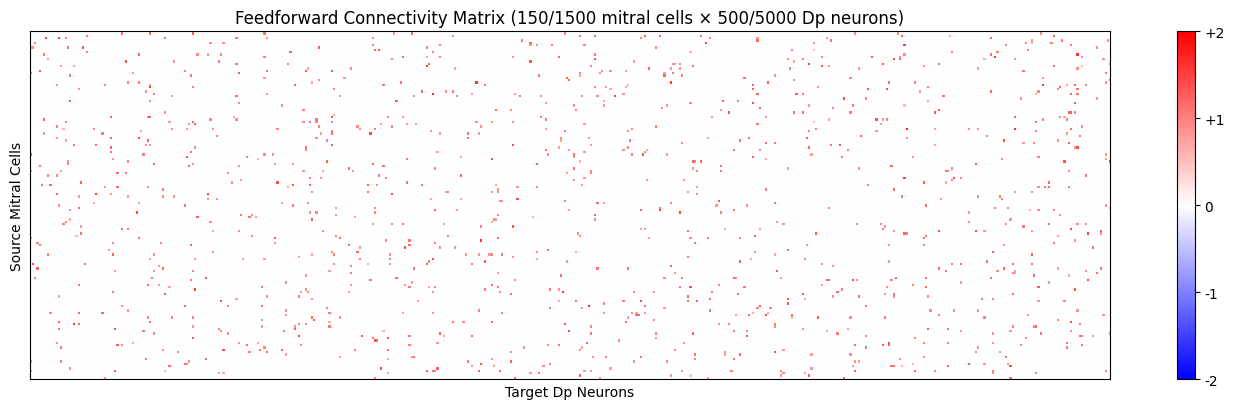

In [19]:
#| code-fold: true
#| code-summary: "Plot feedforward connectivity matrix"
# Visualize feedforward connectivity matrix
plot_fraction = 0.1  # Fraction of neurons to display
n_input, n_output = feedforward_weights.shape
n_input_plot = int(n_input * plot_fraction)
n_output_plot = int(n_output * plot_fraction)

# Make plot bigger - use fixed large size
plot_width = 14
plot_height = plot_width * n_input_plot / n_output_plot

fig, ax = plt.subplots(figsize=(plot_width, plot_height))
im = ax.imshow(feedforward_weights[:n_input_plot, :n_output_plot], cmap="bwr", vmin=-2, vmax=2, aspect='auto', interpolation='nearest')
cbar = plt.colorbar(im, ax=ax, ticks=[-2, -1, 0, 1, 2])
cbar.ax.set_yticklabels(["-2", "-1", "0", "+1", "+2"])
ax.set_title(f"Feedforward Connectivity Matrix ({n_input_plot}/{n_input} mitral cells × {n_output_plot}/{n_output} Dp neurons)")
ax.set_xlabel("Target Dp Neurons")
ax.set_ylabel("Source Mitral Cells")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

### Neuron Physiology Parameters

Before we can simulate a recurrent SNN with this weight matrix, we review the neuron physiology parameters.

These parameters are adapted from [Meissner-Bernard et al. (2025)](https://doi.org/10.1016/j.celrep.2025.115330), which includes a combination of parameters measured in zebrafish Dp and some fit to match experimental network activity recordings in this network.

In [20]:
#| code-fold: true
#| code-summary: "Display physiology parameters"
# Display neuron physiology parameters
physiology_symbols = ['tau_mem_E', 'tau_mem_I', 'tau_syn_E', 'tau_syn_I', 
                      'R_E', 'R_I', 'U_rest_E', 'U_rest_I',
                      'theta_E', 'theta_I', 'U_reset_E', 'U_reset_I']
physiology_params = params_df[params_df['symbol'].isin(physiology_symbols)]

print("Neuron Physiology Parameters (adapted from Meissner-Bernard et al. 2025)")
print("=" * 72)
display(physiology_params.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.2f}'}))


Neuron Physiology Parameters (adapted from Meissner-Bernard et al. 2025)


symbol,unit,description,value
tau_mem_E,ms,Membrane time constant for excitatory neurons,85.00
tau_syn_E,ms,Synaptic time constant for excitatory connections,30.00
R_E,MOhm,Membrane resistance for excitatory neurons,740.74
U_rest_E,mV,Resting membrane potential for excitatory neurons,-60.00
theta_E,mV,Spike threshold voltage for excitatory neurons,-38.00
U_reset_E,mV,Reset voltage after spike for excitatory neurons,-60.00
tau_mem_I,ms,Membrane time constant for inhibitory neurons,50.00
tau_syn_I,ms,Synaptic time constant for inhibitory connections,10.00
R_I,MOhm,Membrane resistance for inhibitory neurons,1111.11
U_rest_I,mV,Resting membrane potential for inhibitory neurons,-60.00


### Neuron input considerations

Prior to running our simulation, we briefly calculate the mean synaptic input to each neuron in the recurrent network from the three possible cell types. This should give an indication of the type of dynamical regime we expect the network to be in.

In [21]:
#| code-fold: true
#| code-summary: "Calculate and display mean inputs"
# Compute mean synaptic input to all recurrent cells

# Mean mitral cell input per recurrent neuron
mitral_input = (
    num_mitral *  # Total number of mitral cells
    p_feedforward *  # Probability of feedforward connection
    np.exp(w_mu_FF + w_sigma_FF**2/2) * scaling_factor_FF  # Expected weight from log-normal distribution
)

p_recurrent = (1/num_assemblies) * p_within + (1 - 1/num_assemblies) * p_between  # Recurrent connection probability

# Mean excitatory input per recurrent neuron
excitatory_input = (
    num_neurons *  # Total number of neurons
    p_recurrent *  # Connection probability
    p_E *  # Fraction of excitatory neurons
    np.exp(w_mu_E + w_sigma_E**2/2) * scaling_factor_E  # Expected excitatory weight
)

# Mean inhibitory input per recurrent neuron
inhibitory_input = (
    num_neurons *  # Total number of neurons
    p_recurrent *  # Connection probability
    (1 - p_E) *  # Fraction of inhibitory neurons
    np.exp(w_mu_I + w_sigma_I**2/2) * scaling_factor_I  # Expected inhibitory weight (negative)
)

# Display mean synaptic inputs
input_data = {
    'Input Source': ['Mitral Cells (FF)', 'Excitatory (Recurrent)', 'Inhibitory (Recurrent)'],
    'Mean Input (pA)': [mitral_input, excitatory_input, inhibitory_input]
}
input_df = pd.DataFrame(input_data)

print("Mean Synaptic Input per Neuron")
print("=" * 30)
display(input_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'Mean Input (pA)': '{:.2f}'}))

Mean Synaptic Input per Neuron


Input Source,Mean Input (pA)
Mitral Cells (FF),0.12
Excitatory (Recurrent),0.40
Inhibitory (Recurrent),0.53


### Initialise network and run simulation

Here we finally initialise our current-based LIF recurrent network with the connectivity and inputs we have created. We run our simulation and plot some sample output spiketrains and statistics from the model.

In [22]:
# Initialize LIF network model and run simulation
model = CurrentLIFNetwork(
    csv_path=repo_root / "parameters" / "Dp-default.csv",
    neuron_types=neuron_types,
    recurrent_weights=weights,
    feedforward_weights=feedforward_weights*scaling_factor_FF,
)

model.initialise_parameters(
    E_weight=scaling_factor_E,
    I_weight=scaling_factor_I,
)

# Move model to device for GPU acceleration
model.to(device)

output_spikes, output_voltages, output_I_exc, output_I_inh = model.forward(
    n_steps=n_steps,
    inputs=input_spikes,
)

Simulating network: 100%|██████████| 1000/1000 [01:19<00:00, 12.54step/s]


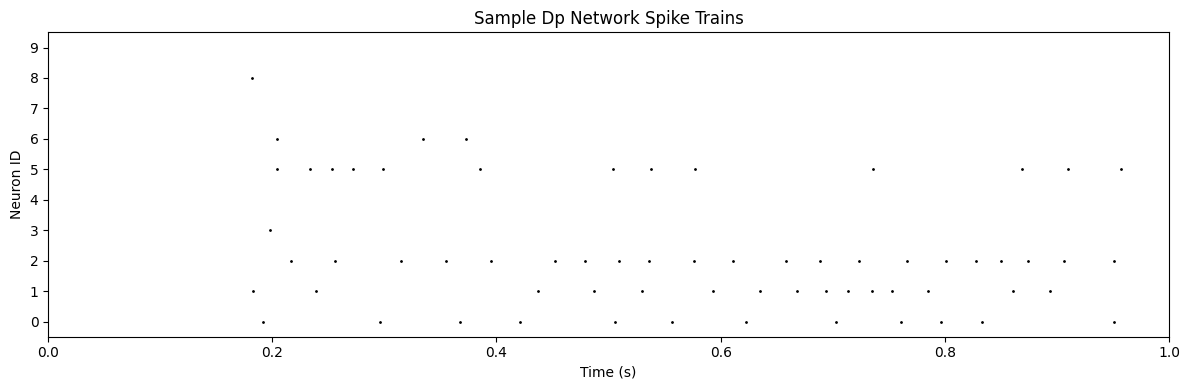

In [23]:
#| code-fold: true
#| code-summary: "Plot network spike trains"
# Visualize Dp network spike trains
n_neurons_plot = 10
fraction = 1.0  # fraction of duration to plot
fig, ax = plt.subplots(figsize=(12, 4))
spike_times, neuron_ids = np.where(output_spikes[0, :, :n_neurons_plot])
ax.scatter(spike_times * delta_t * 1e-3, neuron_ids, s=1, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neuron ID')
ax.set_title('Sample Dp Network Spike Trains')
ax.set_ylim(-0.5, n_neurons_plot - 0.5)
ax.set_yticks(range(n_neurons_plot))
ax.set_xlim(0, duration * 1e-3 * fraction)
plt.tight_layout()
plt.show()

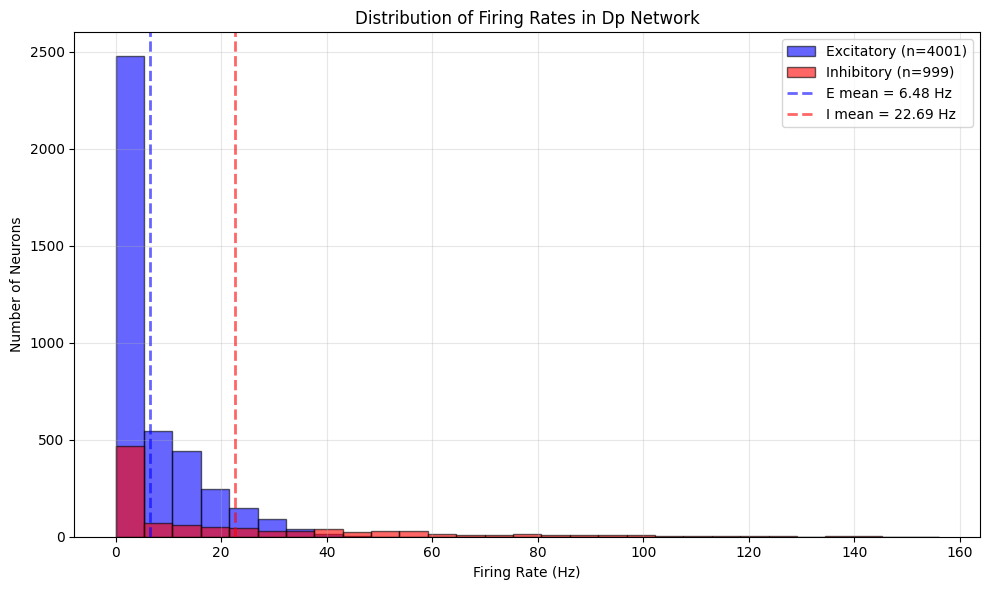

Excitatory neurons: mean = 6.48 Hz, std = 8.40 Hz
Inhibitory neurons: mean = 22.69 Hz, std = 31.18 Hz


In [24]:
#| code-fold: true
#| code-summary: "Plot firing rate distribution"
# Compute and plot firing rates for all neurons
# Calculate firing rates (spikes per second)
spike_counts = output_spikes[0].sum(axis=0).cpu().numpy()  # Total spikes per neuron
firing_rates = spike_counts / (duration * 1e-3)  # Convert duration from ms to s

# Separate firing rates by neuron type
excitatory_rates = firing_rates[neuron_types == 1]
inhibitory_rates = firing_rates[neuron_types == -1]

# Create histogram with bwr colormap colors
fig, ax = plt.subplots(figsize=(10, 6))
bins = np.linspace(0, max(firing_rates.max(), 1), 30)

ax.hist(excitatory_rates, bins=bins, alpha=0.6, color='#0000FF', label=f'Excitatory (n={len(excitatory_rates)})', edgecolor='black')  # Blue from bwr
ax.hist(inhibitory_rates, bins=bins, alpha=0.6, color='#FF0000', label=f'Inhibitory (n={len(inhibitory_rates)})', edgecolor='black')  # Red from bwr

# Add mean lines
ax.axvline(excitatory_rates.mean(), alpha=0.6, color='#0000FF', linestyle='--', linewidth=2, label=f'E mean = {excitatory_rates.mean():.2f} Hz')
ax.axvline(inhibitory_rates.mean(), alpha=0.6, color='#FF0000', linestyle='--', linewidth=2, label=f'I mean = {inhibitory_rates.mean():.2f} Hz')

ax.set_xlabel('Firing Rate (Hz)')
ax.set_ylabel('Number of Neurons')
ax.set_title('Distribution of Firing Rates in Dp Network')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Excitatory neurons: mean = {excitatory_rates.mean():.2f} Hz, std = {excitatory_rates.std():.2f} Hz")
print(f"Inhibitory neurons: mean = {inhibitory_rates.mean():.2f} Hz, std = {inhibitory_rates.std():.2f} Hz")

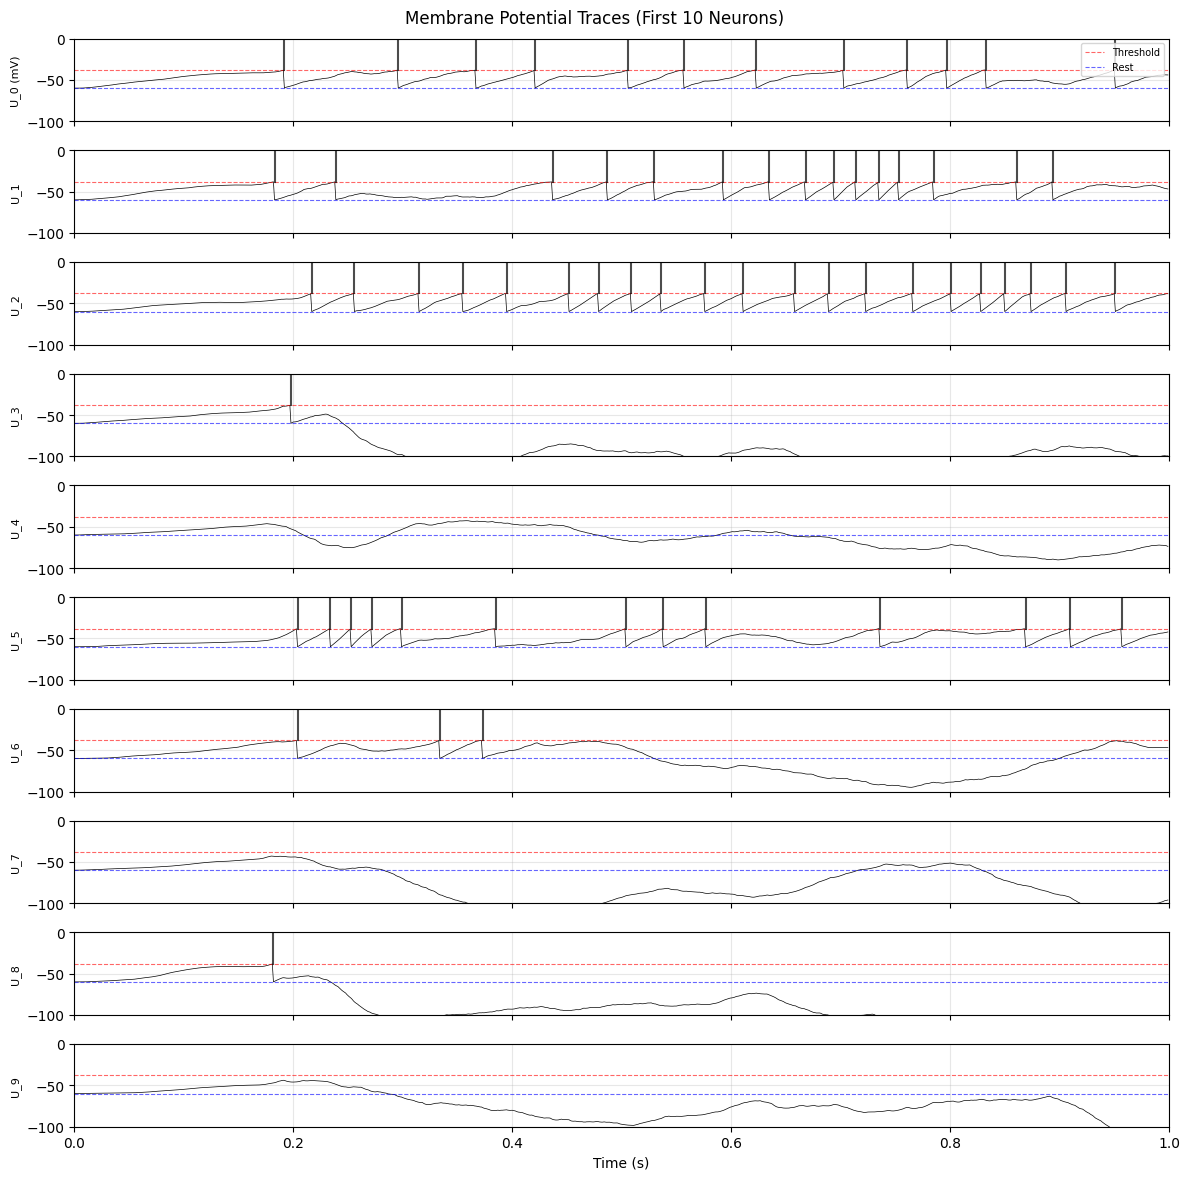

In [28]:
#| code-fold: true
#| code-summary: "Plot membrane voltage traces"
# Visualize membrane voltages for the first 10 neurons
n_neurons_plot = 10
fraction = 1  # fraction of duration to plot
n_steps_plot = int(n_steps * fraction)

# Fixed y-axis range and ticks
y_min = -100
y_max = 0
y_ticks = np.arange(y_min, y_max + 1, 50)

fig, axes = plt.subplots(n_neurons_plot, 1, figsize=(12, 12), sharex=True)
time_axis = np.arange(n_steps_plot) * delta_t * 1e-3  # Convert to seconds

for neuron_id in range(n_neurons_plot):
    voltage_trace = output_voltages[0, :n_steps_plot, neuron_id].detach().cpu().numpy()
    spike_times_neuron = np.where(output_spikes[0, :n_steps_plot, neuron_id].cpu().numpy())[0]
    
    # Plot voltage trace
    axes[neuron_id].plot(time_axis, voltage_trace, linewidth=0.5, color='black')
    
    # Get neuron-specific parameters
    is_excitatory = neuron_types[neuron_id] == 1
    threshold = model.theta_E.item() if is_excitatory else model.theta_I.item()
    rest = model.U_rest_E.item() if is_excitatory else model.U_rest_I.item()
    
    # Add threshold and rest lines
    axes[neuron_id].axhline(y=threshold, color='#FF0000', linestyle='--', linewidth=0.8, alpha=0.6, label='Threshold')
    axes[neuron_id].axhline(y=rest, color='#0000FF', linestyle='--', linewidth=0.8, alpha=0.6, label='Rest')
    
    # Mark spike times with vertical lines from threshold to zero
    if len(spike_times_neuron) > 0:
        spike_times_s = spike_times_neuron * delta_t * 1e-3
        for spike_t in spike_times_s:
            axes[neuron_id].plot([spike_t, spike_t], [threshold, 0], 
                               color='black', linewidth=1.5, alpha=0.7, zorder=5)
    
    axes[neuron_id].set_ylabel(f'U_{neuron_id}', fontsize=8)
    axes[neuron_id].set_xlim(0, duration * 1e-3 * fraction)
    axes[neuron_id].set_ylim(y_min, y_max)
    axes[neuron_id].set_yticks(y_ticks)
    axes[neuron_id].grid(True, alpha=0.3)
    
    # Add legend to first subplot only
    if neuron_id == 0:
        axes[neuron_id].legend(loc='upper right', fontsize=7)

axes[-1].set_xlabel('Time (s)')
axes[0].set_ylabel('U_0 (mV)', fontsize=8)  # Add unit to first ylabel only
fig.suptitle(f'Membrane Potential Traces (First {n_neurons_plot} Neurons)', fontsize=12)
plt.tight_layout()
plt.show()


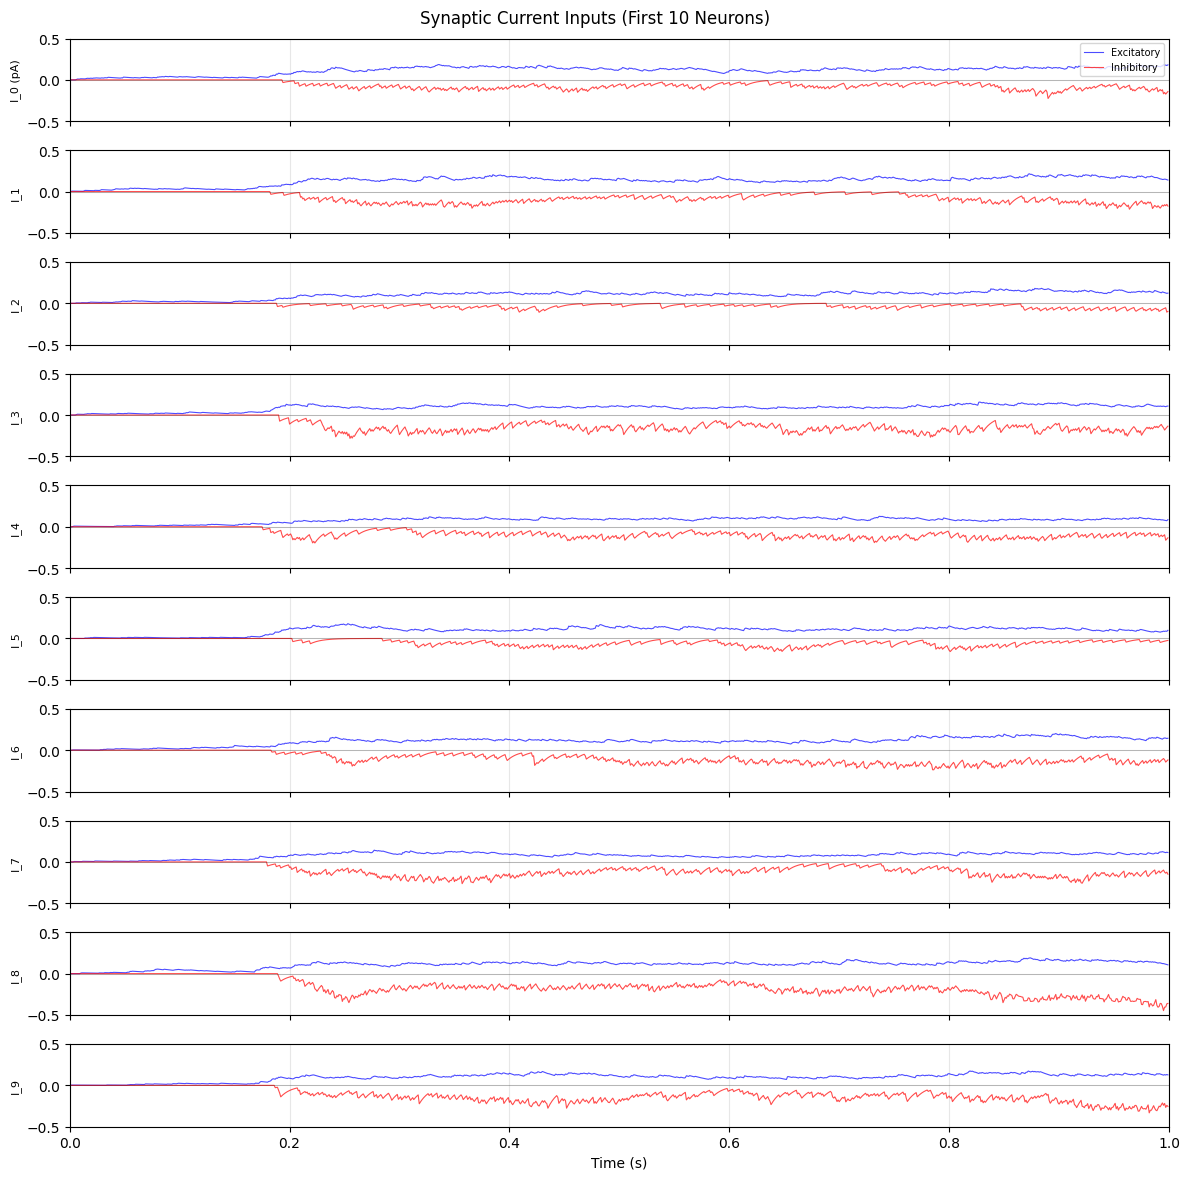

In [31]:
#| code-fold: true
#| code-summary: "Plot synaptic currents by source"
# Visualize synaptic currents for the first 10 neurons
n_neurons_plot = 10
fraction = 1  # fraction of duration to plot
n_steps_plot = int(n_steps * fraction)

# Calculate max absolute value across all neurons for consistent scaling
max_current = 0
for neuron_id in range(n_neurons_plot):
    I_exc_trace = output_I_exc[0, :n_steps_plot, neuron_id].detach().cpu().numpy()
    I_inh_trace = output_I_inh[0, :n_steps_plot, neuron_id].detach().cpu().numpy()
    max_current = max(max_current, np.abs(I_exc_trace).max(), np.abs(I_inh_trace).max())

# Round up to nearest 0.1
y_lim = np.ceil(max_current / 0.1) * 0.1

fig, axes = plt.subplots(n_neurons_plot, 1, figsize=(12, 12), sharex=True)
time_axis = np.arange(n_steps_plot) * delta_t * 1e-3  # Convert to seconds

for neuron_id in range(n_neurons_plot):
    # Extract excitatory and inhibitory currents for this neuron
    I_exc_trace = output_I_exc[0, :n_steps_plot, neuron_id].detach().cpu().numpy()
    I_inh_trace = output_I_inh[0, :n_steps_plot, neuron_id].detach().cpu().numpy()
    
    # Plot excitatory and inhibitory currents
    axes[neuron_id].plot(time_axis, I_exc_trace, linewidth=0.8, color='#0000FF', alpha=0.7, label='Excitatory')
    axes[neuron_id].plot(time_axis, I_inh_trace, linewidth=0.8, color='#FF0000', alpha=0.7, label='Inhibitory')
    
    # Add zero line
    axes[neuron_id].axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Add units only to first ylabel
    ylabel = f'I_0 (pA)' if neuron_id == 0 else f'I_{neuron_id}'
    axes[neuron_id].set_ylabel(ylabel, fontsize=8)
    axes[neuron_id].set_xlim(0, duration * 1e-3 * fraction)
    axes[neuron_id].set_ylim(-y_lim, y_lim)
    axes[neuron_id].grid(True, alpha=0.3)
    
    # Add legend to first subplot only
    if neuron_id == 0:
        axes[neuron_id].legend(loc='upper right', fontsize=7)

axes[-1].set_xlabel('Time (s)')
fig.suptitle(f'Synaptic Current Inputs (First {n_neurons_plot} Neurons)', fontsize=12)
plt.tight_layout()
plt.show()